In [1]:
#TAREA 1
#ADOLFO GODOY
#objetivos:
#1) mostrar y explicar, en 16 gráficos (uno por región), como fue la evolución de la cuarentena (por día) 
# 2) qué dia hubo la mayor cantidad de personas en cuarentena en cada región, 
#3) qué día hubo la mayor cantidad de personas en cuarentena en el país?


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels import robust
%matplotlib inline

In [3]:
pasos=pd.read_csv('https://github.com/MinCiencia/Datos-COVID19/blob/master/input/Paso_a_paso/paso_a_paso.csv?raw=true', sep=',') #seleccione este porque me dice TODOS los dias en que paso se encuentra la comuna, versus otras que me entregaban este dato en rangos de fechas

In [4]:
pob=pd.read_csv('https://github.com/MinCiencia/Datos-COVID19/blob/master/output/producto1/Covid-19.csv?raw=true', sep=',') #leyendo el paper en la rubrica, usaron el producto 1 para tener las poblaciones por regios, asi que tambien lo utilize en este caso
pob2=pob[['Region','Codigo region','Comuna','Codigo comuna','Poblacion']] #no me interesa el numero de casos de covid por dia, por lo que selecciono las columnas que considero utiles y armo otra tabla
pob2=pob2.dropna() #por alguna razon estos datos traen filas estilo "region desconocodia" y datos NaN, por lo que realizo limpieza

In [5]:
pob2.head() #las columnas que me interesan esta tabla en particular son la de poblacion y la de codigo de comuna

,Region,Codigo region,Comuna,Codigo comuna,Poblacion
0,Arica y Parinacota,15,Arica,15101.0,247552.0
1,Arica y Parinacota,15,Camarones,15102.0,1233.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0
5,Tarapacá,1,Alto Hospicio,1107.0,129999.0


In [6]:
pob2.info() #poblacion y codigo de comuna estan en float64, necesito transformarlos a int64 para poder juntarlos con la otra tabla

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 360
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         346 non-null    object 
 1   Codigo region  346 non-null    int64  
 2   Comuna         346 non-null    object 
 3   Codigo comuna  346 non-null    float64
 4   Poblacion      346 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 16.2+ KB


In [7]:
pob2['Poblacion']=pob2['Poblacion'].astype(int)
pob2['Codigo comuna']=pob2['Codigo comuna'].astype(int)

In [8]:
pob2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 360
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Region         346 non-null    object
 1   Codigo region  346 non-null    int64 
 2   Comuna         346 non-null    object
 3   Codigo comuna  346 non-null    int32 
 4   Poblacion      346 non-null    int32 
dtypes: int32(2), int64(1), object(2)
memory usage: 13.5+ KB


In [9]:
pasos.tail() #viendo ahora a la de paso por paso, los dias estan como columnas, por limpieza, los movere a filas con el comando melt

,codigo_region,region_residencia,codigo_comuna,comuna_residencia,zona,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,...,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-02,2021-10-03,2021-10-04,2021-10-05,2021-10-06
381,12,Magallanes,12101,Punta Arenas,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
382,12,Magallanes,12103,Río Verde,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
383,12,Magallanes,12104,San Gregorio,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
384,12,Magallanes,12303,Timaukel,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
385,12,Magallanes,12402,Torres del Paine,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5


In [10]:
pasosm=pasos.melt(id_vars=["codigo_region","region_residencia","codigo_comuna","comuna_residencia","zona"], var_name="fecha", value_name="paso") #con esto tengo el paso de cada comuna, en cada dia, pero solo necesito los paso 1 (que son los paso "cuarentena")

In [11]:
pasosm1=pasosm
pasosm1 #antes aca tenia una serie de comandos, pero lo removi porque me di cuenta que no llevaba al resultado que se busca, para evitar que se me rompiera todo retroactivamente, hice este cambio de nombre

,codigo_region,region_residencia,codigo_comuna,comuna_residencia,zona,fecha,paso
0,15,Arica y Parinacota,15101,Arica,Rural,2020-07-28,3
1,15,Arica y Parinacota,15101,Arica,Urbana,2020-07-28,1
2,15,Arica y Parinacota,15102,Camarones,Total,2020-07-28,3
3,15,Arica y Parinacota,15202,General Lagos,Total,2020-07-28,3
4,15,Arica y Parinacota,15201,Putre,Total,2020-07-28,3
...,...,...,...,...,...,...,...
168291,12,Magallanes,12101,Punta Arenas,Total,2021-10-06,5
168292,12,Magallanes,12103,Río Verde,Total,2021-10-06,5
168293,12,Magallanes,12104,San Gregorio,Total,2021-10-06,5
168294,12,Magallanes,12303,Timaukel,Total,2021-10-06,5


In [12]:
pasosm1=pasosm1.rename(columns={'codigo_comuna':'Codigo comuna'}) #ahora quiero juntar esta tabla a la que tiene las poblaciones, por lo que las juntare por la columna comun que tienen de codigos de comuna, igualo nombres para poder juntarlas

In [13]:
pasosm1.drop('zona', axis=1, inplace=True)#esta columna en particular me esta generando problemas mas abajo para eliminar ingresos duplicados de poblacion, asi que la remuevo ahora

In [14]:
paspob=pob2.merge(pasosm1, on='Codigo comuna')  #junto las tablas (y creo otra para hacer algo mas adelante)
paspobr=pob2.merge(pasosm1, on='Codigo comuna') #creo esta tabla para separar la tabla que ocupo para ver la poblacion total (paspob) versus la que usare para separar por regiones (paspobr)

In [15]:
cambio2 = (paspob['paso'] == 2)
paspob['Poblacion'][cambio2] = 0
cambio3 = (paspob['paso'] == 3)
paspob['Poblacion'][cambio3] = 0
cambio4 = (paspob['paso'] == 4)
paspob['Poblacion'][cambio4] = 0
cambio5 = (paspob['paso'] == 5)
paspob['Poblacion'][cambio5] = 0
paspob #con esto, contabilizo los dias que existen entre fechas de pandemia, si no los contabilizara, luego cuando haga un grafico, mostraria lineas rectas entre fechas con cuerentena y no tomaria en cuenta los valles sin cuarentena 

<ipython-input-15-00172e771c6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspob['Poblacion'][cambio2] = 0
<ipython-input-15-00172e771c6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspob['Poblacion'][cambio3] = 0
<ipython-input-15-00172e771c6c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspob['Poblacion'][cambio4] = 0
<ipython-input-15-00172e771c6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,fecha,paso
0,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-28,3
1,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,2020-07-28,1
2,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-29,3
3,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,2020-07-29,1
4,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-30,3
...,...,...,...,...,...,...,...,...,...,...
168291,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-02,4
168292,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-03,4
168293,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-04,4
168294,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-05,4


In [16]:
cambior2 = (paspobr['paso'] == 2)
paspobr['Poblacion'][cambior2] = 0
cambior3 = (paspobr['paso'] == 3)
paspobr['Poblacion'][cambior3] = 0
cambior4 = (paspobr['paso'] == 4)
paspobr['Poblacion'][cambior4] = 0
cambior5 = (paspobr['paso'] == 5)
paspobr['Poblacion'][cambior5] = 0
paspobr

<ipython-input-16-556d5eab6920>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspobr['Poblacion'][cambior2] = 0
<ipython-input-16-556d5eab6920>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspobr['Poblacion'][cambior3] = 0
<ipython-input-16-556d5eab6920>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspobr['Poblacion'][cambior4] = 0
<ipython-input-16-556d5eab6920>:8: SettingWithCopyWarning: 
A value is trying to be set on 

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,fecha,paso
0,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-28,3
1,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,2020-07-28,1
2,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-29,3
3,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,2020-07-29,1
4,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-30,3
...,...,...,...,...,...,...,...,...,...,...
168291,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-02,4
168292,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-03,4
168293,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-04,4
168294,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,2021-10-05,4


In [17]:
paspob=paspob.sort_values(by='fecha', ascending=True)  #ordeno por fechas, vale mencionar que si ejecuto esto multiples veces, las comunas aparecen en distinto orden, pero siguen ordenadas por fecha
paspob

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,fecha,paso
0,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,2020-07-28,3
118592,Araucanía,9,Curacautin,9203,0,9,La Araucanía,Curacautín,2020-07-28,4
118156,Araucanía,9,Cunco,9103,0,9,La Araucanía,Cunco,2020-07-28,4
117720,Araucanía,9,Collipulli,9202,0,9,La Araucanía,Collipulli,2020-07-28,4
6540,Antofagasta,2,Calama,2201,190336,2,Antofagasta,Calama,2020-07-28,1
...,...,...,...,...,...,...,...,...,...,...
113795,Biobío,8,Santa Barbara,8311,0,8,Biobío,Santa Bárbara,2021-10-06,4
114231,Biobío,8,Santa Juana,8109,0,8,Biobío,Santa Juana,2021-10-06,4
114667,Biobío,8,Talcahuano,8110,0,8,Biobío,Talcahuano,2021-10-06,4
83711,Maule,7,Parral,7404,0,7,Maule,Parral,2021-10-06,3


In [18]:
paspobr.drop('paso', axis=1, inplace=True)
paspobr.drop('Comuna', axis=1, inplace=True)
paspobr.drop('Codigo comuna', axis=1, inplace=True)
paspobr.drop('Region', axis=1, inplace=True)
paspobr.drop('Codigo region', axis=1, inplace=True)
paspobr.drop('comuna_residencia', axis=1, inplace=True)
paspobr.drop('region_residencia', axis=1, inplace=True)

In [19]:
paspob.drop('paso', axis=1, inplace=True)
paspob.drop('Comuna', axis=1, inplace=True)
paspob.drop('Codigo comuna', axis=1, inplace=True)
paspob.drop('codigo_region', axis=1, inplace=True)
paspob.drop('Codigo region', axis=1, inplace=True)
#lo que voy a hacer es un groupby, pero antes remuevo las columnas que tienen numeros, para evitar que aparezcan sumas inutiles (como por ejemplo pasos = 60 si no lo removiera para lo que hago mas abajo)

In [20]:
paspob=paspob.drop_duplicates()#algunas comunas tienen una sub division de tipo de zona (Rural, Urbana y Total), sin embargo, en los datos tienen exactamente la misma poblacion, lo que resultaba en situacion como por ejemplo, Arica tuviera tanto la zona Urbana como la Rural en cuarentena, pero al poseer la misma poblacion, el resultado daba que el 200% de la poblacion de Arica estaba en cuarentena, con tal de evitar doble conteo de Poblacion, se elimino la columna de zona, y luego se utilizo drop duplicate
paspobr=paspobr.drop_duplicates()

paspob

,Region,Poblacion,region_residencia,comuna_residencia,fecha
0,Arica y Parinacota,0,Arica y Parinacota,Arica,2020-07-28
118592,Araucanía,0,La Araucanía,Curacautín,2020-07-28
118156,Araucanía,0,La Araucanía,Cunco,2020-07-28
117720,Araucanía,0,La Araucanía,Collipulli,2020-07-28
6540,Antofagasta,190336,Antofagasta,Calama,2020-07-28
...,...,...,...,...,...
113795,Biobío,0,Biobío,Santa Bárbara,2021-10-06
114231,Biobío,0,Biobío,Santa Juana,2021-10-06
114667,Biobío,0,Biobío,Talcahuano,2021-10-06
83711,Maule,0,Maule,Parral,2021-10-06


In [21]:
t=paspob.groupby(['fecha']).sum() 
t
#con esto tengo el total de poblacion que se encuentra en cuarentena cada día en el pais

,Poblacion
fecha,
2020-07-28,9833441
2020-07-29,10609230
2020-07-30,10609230
2020-07-31,10609230
2020-08-01,10609230
...,...
2021-10-02,0
2021-10-03,0
2021-10-04,0


<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

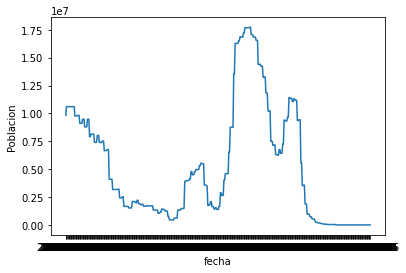

In [22]:
sns.lineplot(x='fecha', y='Poblacion', data=t)

In [23]:
t.loc[t['Poblacion'] == t.max()[0]] #asi, obtengo las fechas donde la numero de personas en cuarentena en todo el pais alcanzo su valor maximo, el que fue de 19191466 personas en las fechas 17 y 18 Abril del año 2021

,Poblacion
fecha,
2021-04-17,17726944
2021-04-18,17726944


In [24]:
paspobr1=paspobr[(paspobr['codigo_region']==1)] # TARAPACA
paspobr2=paspobr[(paspobr['codigo_region']==2)] # ANTOFAGASTA
paspobr3=paspobr[(paspobr['codigo_region']==3)] # ATACAMA
paspobr4=paspobr[(paspobr['codigo_region']==4)] # COQUIMBO
paspobr5=paspobr[(paspobr['codigo_region']==5)] # VALPARAISO
paspobr6=paspobr[(paspobr['codigo_region']==6)] # O'HIGGINS
paspobr7=paspobr[(paspobr['codigo_region']==7)] # EL MAULE
paspobr8=paspobr[(paspobr['codigo_region']==8)] # EL BIOBIO
paspobr9=paspobr[(paspobr['codigo_region']==9)] # LA ARAUCANIA
paspobr10=paspobr[(paspobr['codigo_region']==10)] # LOS LAGOS
paspobr11=paspobr[(paspobr['codigo_region']==11)] # AYSEN
paspobr12=paspobr[(paspobr['codigo_region']==12)] # MAGALLANES Y LA ANTARTICA CHILENA
paspobr13=paspobr[(paspobr['codigo_region']==13)] # METROPOLITANA DE SANTIAGO
paspobr14=paspobr[(paspobr['codigo_region']==14)] # LOS RIOS
paspobr15=paspobr[(paspobr['codigo_region']==15)] # ARICA Y PARINACOTA
paspobr16=paspobr[(paspobr['codigo_region']==16)] # ÑUBLE
#Puedo crear distintas tablas que solo contengan una region en particular segun el codigo de region que posea, tomando la condicion de ir tomando "codigo_region" de 1 a 16

In [25]:
paspobr1.drop('codigo_region', axis=1, inplace=True)
paspobr2.drop('codigo_region', axis=1, inplace=True)
paspobr3.drop('codigo_region', axis=1, inplace=True)
paspobr4.drop('codigo_region', axis=1, inplace=True)
paspobr5.drop('codigo_region', axis=1, inplace=True)
paspobr6.drop('codigo_region', axis=1, inplace=True)
paspobr7.drop('codigo_region', axis=1, inplace=True)
paspobr8.drop('codigo_region', axis=1, inplace=True)
paspobr9.drop('codigo_region', axis=1, inplace=True)
paspobr10.drop('codigo_region', axis=1, inplace=True)
paspobr11.drop('codigo_region', axis=1, inplace=True)
paspobr12.drop('codigo_region', axis=1, inplace=True)
paspobr13.drop('codigo_region', axis=1, inplace=True)
paspobr14.drop('codigo_region', axis=1, inplace=True)
paspobr15.drop('codigo_region', axis=1, inplace=True)
paspobr16.drop('codigo_region', axis=1, inplace=True)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

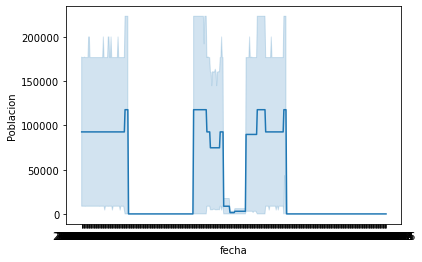

In [26]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr1) #realizo graficos de cada region, el x se ve como una linea negre porque son todos los dias dentro de los datos 

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

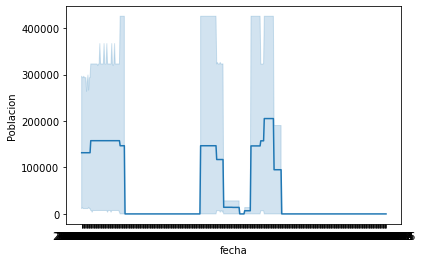

In [27]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr2)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

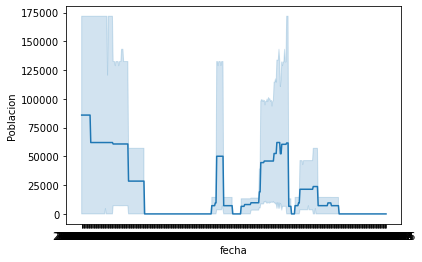

In [28]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr3)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

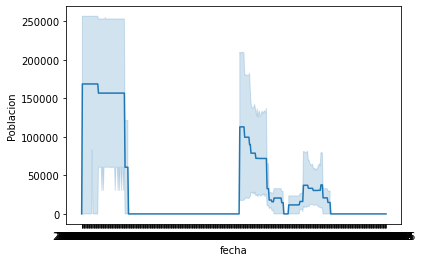

In [29]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr4)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

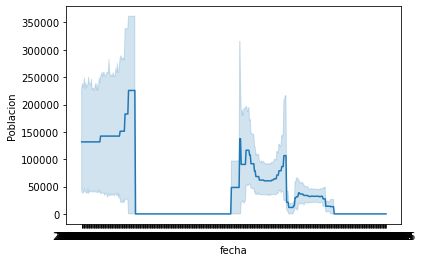

In [30]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr5)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

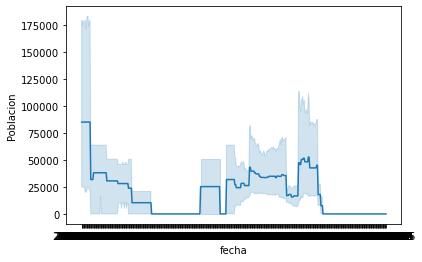

In [31]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr6)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

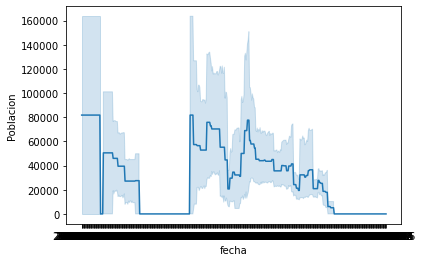

In [32]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr7)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

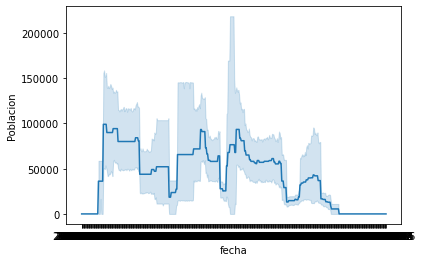

In [33]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr8)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

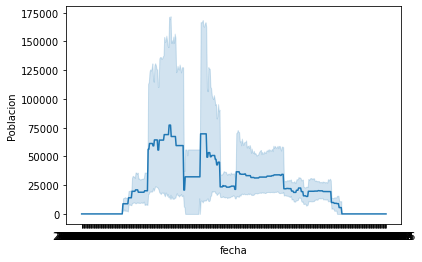

In [34]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr9)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

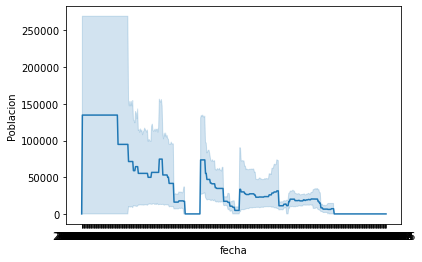

In [35]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr10)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

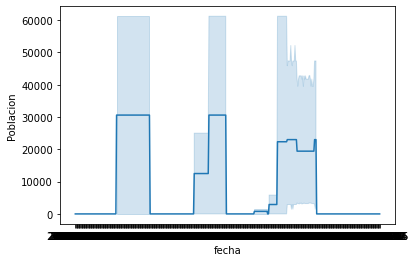

In [36]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr11)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

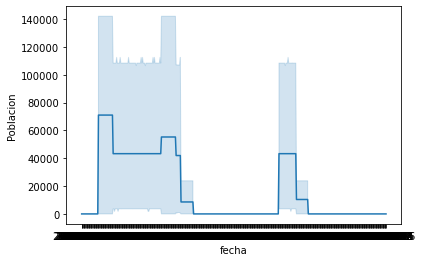

In [37]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr12)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

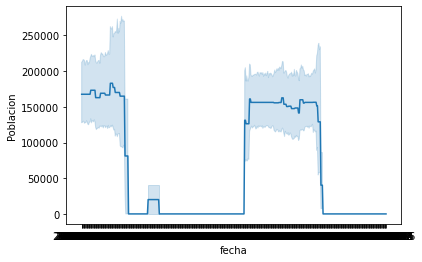

In [38]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr13)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

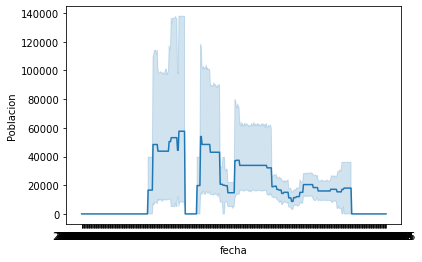

In [39]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr14)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

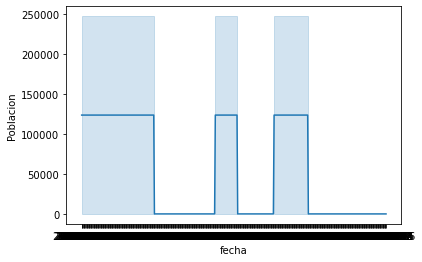

In [40]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr15)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

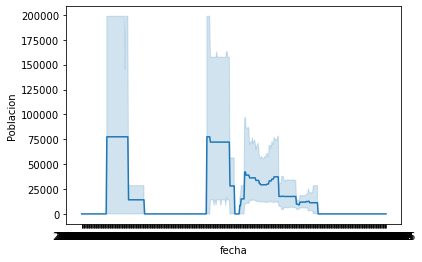

In [41]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr16)

In [42]:
paspobr16.groupby(['fecha']).sum() #por groupby, puedo ver en cada fecha el total de poblacion que se encontraba en cuarentena en la region, usare la letra s# para acortar codigo para adelante

,Poblacion
fecha,
2020-07-28,0
2020-07-29,0
2020-07-30,0
2020-07-31,0
2020-08-01,0
...,...
2021-10-02,0
2021-10-03,0
2021-10-04,0


In [43]:
s1=paspobr1.groupby(['fecha']).sum()
s2=paspobr2.groupby(['fecha']).sum()
s3=paspobr3.groupby(['fecha']).sum()
s4=paspobr4.groupby(['fecha']).sum()
s5=paspobr5.groupby(['fecha']).sum()
s6=paspobr6.groupby(['fecha']).sum()
s7=paspobr7.groupby(['fecha']).sum()
s8=paspobr8.groupby(['fecha']).sum()
s9=paspobr9.groupby(['fecha']).sum()
s10=paspobr10.groupby(['fecha']).sum()
s11=paspobr11.groupby(['fecha']).sum()
s12=paspobr12.groupby(['fecha']).sum()
s13=paspobr13.groupby(['fecha']).sum()
s14=paspobr14.groupby(['fecha']).sum()
s15=paspobr15.groupby(['fecha']).sum()
s16=paspobr16.groupby(['fecha']).sum()

In [44]:
s1

,Poblacion
fecha,
2020-07-28,370857
2020-07-29,370857
2020-07-30,370857
2020-07-31,370857
2020-08-01,370857
...,...
2021-10-02,0
2021-10-03,0
2021-10-04,0


In [45]:
s1.max()[0]

373857

In [46]:
s1.loc[s1['Poblacion'] == s1.max()[0]] #con esto obtengo todos los dias donde la region tuvo el maximo valor, repito lo mismo para cada region y obtendre las fechas donde la region alcanzo el maximo de personas en cuarentena

,Poblacion
fecha,
2021-01-28,373857
2021-01-29,373857
2021-01-30,373857
2021-01-31,373857
2021-02-01,373857
2021-02-02,373857
2021-02-03,373857
2021-02-04,373857
2021-02-05,373857


In [47]:
s2.loc[s2['Poblacion'] == s2.max()[0]]

,Poblacion
fecha,
2020-07-28,658916
2020-07-29,658916
2020-07-30,658916
2020-07-31,658916
2020-08-01,658916
2020-08-02,658916
2020-08-03,658916
2020-08-04,658916
2020-08-05,658916


In [48]:
s3.loc[s3['Poblacion'] == s3.max()[0]]

,Poblacion
fecha,
2021-04-15,275723
2021-04-16,275723
2021-04-17,275723
2021-04-18,275723
2021-04-19,275723
2021-04-20,275723
2021-04-21,275723
2021-04-22,275723
2021-04-23,275723


In [49]:
s4.loc[s4['Poblacion'] == s4.max()[0]]

,Poblacion
fecha,
2021-04-03,793772
2021-04-04,793772
2021-04-05,793772
2021-04-06,793772
2021-04-07,793772


In [50]:
s5.loc[s5['Poblacion'] == s5.max()[0]]

,Poblacion
fecha,
2021-04-15,1875007
2021-04-16,1875007
2021-04-17,1875007
2021-04-18,1875007
2021-04-19,1875007
2021-04-20,1875007
2021-04-21,1875007
2021-04-22,1875007
2021-04-23,1875007


In [51]:
s6.loc[s6['Poblacion'] == s6.max()[0]]

,Poblacion
fecha,
2021-04-10,845196
2021-04-11,845196
2021-04-12,845196
2021-04-13,845196
2021-04-14,845196


In [52]:
s7.loc[s7['Poblacion'] == s7.max()[0]]

,Poblacion
fecha,
2021-04-17,1090244
2021-04-18,1090244
2021-04-19,1090244
2021-04-20,1090244
2021-04-21,1090244
2021-04-22,1090244
2021-04-23,1090244
2021-04-24,1090244
2021-04-25,1090244


In [53]:
s8.loc[s8['Poblacion'] == s8.max()[0]]

,Poblacion
fecha,
2021-04-03,1610933
2021-04-04,1610933


In [54]:
s9.loc[s9['Poblacion'] == s9.max()[0]]

,Poblacion
fecha,
2021-04-03,1002155
2021-04-04,1002155
2021-04-05,1002155
2021-04-06,1002155
2021-04-07,1002155


In [55]:
s10.loc[s10['Poblacion'] == s10.max()[0]]

,Poblacion
fecha,
2021-02-06,868037
2021-02-07,868037
2021-02-08,868037
2021-02-09,868037
2021-02-10,868037
2021-02-11,868037
2021-02-12,868037
2021-02-13,868037
2021-02-14,868037


In [56]:
s11.loc[s11['Poblacion'] == s11.max()[0]]

,Poblacion
fecha,
2021-06-10,97161
2021-06-11,97161
2021-06-12,97161
2021-06-13,97161
2021-06-14,97161
2021-06-15,97161
2021-06-16,97161
2021-06-17,97161
2021-06-18,97161


In [57]:
s12.loc[s12['Poblacion'] == s12.max()[0]]

,Poblacion
fecha,
2020-09-11,173089
2020-09-12,173089
2020-09-13,173089
2020-09-14,173089
2020-09-15,173089
...,...
2021-05-26,173089
2021-05-27,173089
2021-05-28,173089


In [58]:
s13.loc[s13['Poblacion'] == s13.max()[0]]

,Poblacion
fecha,
2021-03-27,8125072
2021-03-28,8125072
2021-03-29,8125072
2021-03-30,8125072
2021-03-31,8125072
2021-04-01,8125072
2021-04-02,8125072
2021-04-03,8125072
2021-04-04,8125072


In [59]:
s14.loc[s14['Poblacion'] == s14.max()[0]]

,Poblacion
fecha,
2021-03-11,405835
2021-03-12,405835
2021-03-13,405835
2021-03-14,405835
2021-03-15,405835
2021-03-16,405835
2021-03-17,405835
2021-03-18,405835
2021-03-19,405835


In [60]:
s15.loc[s15['Poblacion'] == s15.max()[0]]

,Poblacion
fecha,
2020-07-28,247552
2020-07-29,247552
2020-07-30,247552
2020-07-31,247552
2020-08-01,247552
...,...
2021-06-12,247552
2021-06-13,247552
2021-06-14,247552


In [61]:
s16.loc[s16['Poblacion'] == s16.max()[0]]

,Poblacion
fecha,
2021-04-10,439164
2021-04-11,439164
2021-04-12,439164
2021-04-13,439164
2021-04-14,439164
2021-04-15,439164
2021-04-16,439164
2021-04-17,439164
2021-04-18,439164
